In [1]:
from pysme.synthesize import synthesize_spectrum
from pysme.linelist.linelist import LineList
from pysme.linelist.vald import ValdFile
from pysme.sme import SME_Structure
from pysme.util import vac2air
from pysme.solve import solve
from pysme.abund import Abund
from pysme import util

from scipy.interpolate import interp1d
from joblib import Parallel, delayed
from scipy.signal import find_peaks
from astropy.constants import c as c_light
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import numpy as np
import warnings
import glob
import sys
import os

warnings.filterwarnings('ignore')

Missing colon in file PosixPath('/misc/store/home_zztop/fgran/.local/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/seaborn-v0_8.mplstyle'), line 1 ('\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

In [2]:
os.chdir('/home/fgran/iSpec/')
import ispec
sys.path.append('/home/fgran/iSpec/')

In [3]:
def pix_to_wl(pix, wl0, dwl):
    return wl0 + pix * dwl

In [4]:
os.environ['NUMEXPR_MAX_THREADS'] = '35' #change this number using the correct number of cores/threads in jupyter.slurm

In [5]:
#Load Cayrel-LP results

In [6]:
os.chdir('/store/teams/cosmos/fgran/data/Pristine-UVES/')
stars = sorted(glob.glob('/store/teams/cosmos/hill/hill_extern7bis/LP/LPgiants/*/'))[:-1]

In [7]:
cayrel = pd.read_csv('tmp_merged/cayrel_loggbc_lp.csv')
cayrel.drop(columns=['vmac', 'evmac_sme', 'evmac_fit'], inplace=True)
cayrel_fe = pd.read_csv('tmp_cayrel/cayrel_fe.csv')

cayrel = cayrel.merge(right=cayrel_fe, on='spec_id')

In [8]:
cayrel.head(2)

,spec_id,teff,eteff_sme,eteff_fit,logg,elogg_sme,elogg_fit,monh,emonh_sme,emonh_fit,...,logg_cayrel,monh_cayrel,vmic_cayrel,fe,efe_sme,efe_fit,vmac,evmac_sme,evmac_fit,sme_vrad1
0,01_HD2796,4939.899305,204.934803,11.533078,1.851909,0.047986,0.047986,-2.349789,0.215940,0.013301,...,1.5,-2.47,2.1,7.479476,0.187220,0.010326,8.060534,3.096533,0.140182,1.862572
1,02_HD122563,4581.238720,163.183116,8.732404,1.328129,0.060962,0.060962,-2.679967,0.186471,0.010661,...,1.1,-2.82,2.0,7.423514,0.195194,0.008960,7.751097,3.291346,0.121694,1.046303


In [9]:
# %%time
# lls = sorted(glob.glob('linelist/*_VALD*.lin'))
# linelist = pd.DataFrame()
# for ll in lls:
#     if ('CH' in ll) | ('CN' in ll) | ('NH' in ll) | ('Fe' in ll):
#         linelist = pd.concat([linelist, pd.DataFrame(ValdFile(ll))])
#     else:
#         continue
#         linelist = pd.concat([linelist, pd.DataFrame(ValdFile(ll)).query('gflog > -3.')])
#     linelist = linelist[linelist.species.str.contains('1') | linelist.species.str.contains('2')]
#     # linelist = linelist[linelist.gflog > -3]

# #Carbon scaled to metal-poor
# linelist.gflog[linelist.reference.str.contains('(12)CH')] = np.log10(1.0 * 10**linelist.gflog.values)
# linelist.gflog[linelist.reference.str.contains('(13)CH')] = np.log10((1./5.) * 10**linelist.gflog.values)

# # #Ba r-process scaled
# # linelist.gflog[linelist.reference.str.contains('130')] = -7.0
# # linelist.gflog[linelist.reference.str.contains('132')] = -7.0
# # linelist.gflog[linelist.reference.str.contains('134')] = -7.0
# # linelist.gflog[linelist.reference.str.contains('135')] = np.log10(0.40 * 10**linelist_ba.gflog.values)
# # linelist.gflog[linelist.reference.str.contains('136')] = -7.0
# # linelist.gflog[linelist.reference.str.contains('137')] = np.log10(0.32 * 10**linelist_ba.gflog.values)
# # linelist.gflog[linelist.reference.str.contains('138')] = np.log10(0.28 * 10**linelist_ba.gflog.values)

# linelist = LineList(linedata=linelist, medium='air').sort()
# # linelist = LineList(linelist)

In [10]:
#pysme that only need to be executed once
# linelist = ValdFile('linelist/3800-6800_long.lin')
# linelist_eu = ValdFile('linelist/Eu_long.lin')
# linelist_sr = ValdFile('linelist/Sr_long.lin')
# linelist_ba = ValdFile('linelist/Ba_long.lin')

# linelist = pd.DataFrame(linelist)

# linelist_eu = pd.DataFrame(linelist_eu)
# linelist_eu['depth'] = np.zeros_like(linelist_eu.species.values)
# linelist_sr = pd.DataFrame(linelist_sr)
# linelist_sr['depth'] = np.zeros_like(linelist_sr.species.values)
# linelist_ba = pd.DataFrame(linelist_ba)
# linelist_ba['depth'] = np.zeros_like(linelist_ba.species.values)

# linelist_eu.gflog[~linelist_eu.reference.str.contains('151|153')] = -1.0 #np.log10(1 * 10**linelist_eu.gflog.values)
# linelist_eu.gflog[linelist_eu.reference.str.contains('151')] = np.log10(1 * 10**linelist_eu.gflog.values)
# linelist_eu.gflog[linelist_eu.reference.str.contains('153')] = np.log10(2 * 10**linelist_eu.gflog.values)

# linelist_eu = linelist_eu[(linelist_eu.wlcent > 4120) & (linelist_eu.wlcent < 4210)]

# linelist_ba.gflog[linelist_ba.reference.str.contains('130')] = -1.0 #np.log10(0.0 * 10**linelist_ba.gflog.values)
# linelist_ba.gflog[linelist_ba.reference.str.contains('132')] = -1.0 #np.log10(0.135 * 10**linelist_ba.gflog.values)
# linelist_ba.gflog[linelist_ba.reference.str.contains('134')] = -1.0 #np.log10(0.135 * 10**linelist_ba.gflog.values)
# linelist_ba.gflog[linelist_ba.reference.str.contains('135')] = np.log10(0.42 * 10**linelist_ba.gflog.values)
# linelist_ba.gflog[linelist_ba.reference.str.contains('136')] = -1.0 #np.log10(0.135 * 10**linelist_ba.gflog.values)
# linelist_ba.gflog[linelist_ba.reference.str.contains('137')] = np.log10(0.32 * 10**linelist_ba.gflog.values)
# linelist_ba.gflog[linelist_ba.reference.str.contains('138')] = np.log10(0.28 * 10**linelist_ba.gflog.values)

# linelist = linelist[linelist.species.values != 'Eu 2']
# linelist = linelist[linelist.species.values != 'Sr 2']
# linelist = linelist[linelist.species.values != 'Ba 2']
# linelist = pd.concat([linelist, linelist_eu, linelist_sr, linelist_ba], ignore_index=True).sort_values(by='wlcent', ascending=True).reset_index(drop=True)

# linelist = LineList(linedata=linelist)

# linelist = ValdFile('linelist/VALD_korg_linelist_3000_9000.lin', medium='air')
# linelist.wlcent = vac2air(linelist.wlcent, 'A')

# ll_columns = ['species', 'wlcent', 'excit', 'gflog', 'gamvw', 'gamrad', 'gamqst', 'upper_level', 'lower_level', 'eqw', 'eeqw', 'reference']
# linelist = ValdFile('linelist/3800-6800_short.lin')
# linelist_eu = pd.read_csv('linelist/Eu_Cayrel_linelist.lin', names=ll_columns)
# linelist_ba = pd.read_csv('linelist/Ba_Cayrel_linelist.lin', names=ll_columns)
# linelist_sr = pd.read_csv('linelist/Sr_Cayrel_linelist.lin', names=ll_columns)

# linelist_eu['vmic'], linelist_eu['lande'], linelist_eu['depth'], linelist_eu['atom_number'], linelist_eu['ionization'] = 2.0, 99.0, 0.0, 63.0, 2.0, 
# linelist_ba['vmic'], linelist_ba['lande'], linelist_ba['depth'], linelist_ba['atom_number'], linelist_ba['ionization'] = 2.0, 99.0, 0.0, 56.0, 2.0, 
# linelist_sr['vmic'], linelist_sr['lande'], linelist_sr['depth'], linelist_sr['atom_number'], linelist_sr['ionization'] = 2.0, 99.0, 0.0, 38.0, 2.0, 

# linelist = pd.DataFrame(linelist)

# linelist = linelist[linelist.species.values != 'Eu 2']
# linelist = linelist[linelist.species.values != 'Sr 2']
# linelist = linelist[linelist.species.values != 'Ba 2']
# linelist = pd.concat([linelist, linelist_eu, linelist_sr, linelist_ba], ignore_index=True).sort_values(by='wlcent', ascending=True).reset_index(drop=True)
# linelist = LineList(linedata=linelist)

# ll_columns = ['species', 'wlcent', 'excit', 'gflog', 'fdamp', 'g_up', 'gamrad', 'gamqst', 'upper_level', 'lower_level', 'depth', 'eeqw', 'reference']
# linelist = pd.read_csv('linelist/syn_all_3000_4570_newgfsHFS_Sep07_clean.csv', names=ll_columns, usecols=(0,1,2,3))
# linelist.species = linelist.species.str.replace("'", '')
# linelist['vmic'], linelist['lande'], linelist['atom_number'], linelist['ionization'], linelist['reference'] = 2.0, 1.9, 1.0, 2.0, 'Cayrel_Hill'
# linelist['gamrad'], linelist['gamqst'], linelist['gamvw'] = 0.0, 0.0, 0.0 #7.5, -6.0, -7.7
# linelist = LineList(linedata=linelist, medium='air')
# linelist = linelist.sort()

# lls = sorted(glob.glob('linelist/*_VALD_all.lin'))
# linelist = pd.DataFrame()
# for ll in lls:
#     if ('CN' in ll) or ('CH' in ll) or ('NH' in ll):
#         continue
#     print(ll)
#     linelist = pd.concat([linelist, pd.DataFrame(ValdFile(ll))]);

# linelist = linelist[(linelist.species.str.contains('1').values | linelist.species.str.contains('2').values) & (linelist.gflog.values > -5.)]
# linelist = LineList(linedata=linelist, medium='air')
# linelist = linelist.sort()

# wmin_blue = 4200 #3800
# wmax_blue = 4350

# linelist = linelist[(linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue)]

# #Delta lines definitions
# delta_line = 1. #AA

# wl_G_band = 4300. #AA
# delta_G_band = 40. #AA
# wl_CaHK_band = 3950. #AA
# delta_CaHK_band = 50. #AA
# delta_H_line_wing = 5.0 #AA
# delta_H_line_core = 0.75 #AA

In [11]:
linelist = ValdFile('linelist/VALD_korg_linelist_3000_9000.lin', medium='air')
linelist.wlcent = vac2air(linelist.wlcent, 'A')

[2025-01-24 09:48:02,800] [INFO] [vald:loads:174]: Loading VALD file linelist/VALD_korg_linelist_3000_9000.lin


INFO - Loading VALD file linelist/VALD_korg_linelist_3000_9000.lin


In [12]:
# linelist = LineList(linelist)

wmin_blue = 4200
wmax_blue = 4350

# wmin_blue = 4228.5
# wmax_blue = 4233.5

linelist = linelist[(linelist.wlcent > wmin_blue) & (linelist.wlcent < wmax_blue)]

#Delta lines definitions
delta_line = 1. #AA

wl_G_band = 4300. #AA
delta_G_band = 40. #AA
wl_CaHK_band = 3950. #AA
delta_CaHK_band = 50. #AA
delta_H_line_wing = 5.0 #AA
delta_H_line_core = 0.75 #AA

In [13]:
#Create solar scaled atmosphere with [alpha/Fe] = +0.4
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

abund = solar.abund.pattern
abund['O']  = abund['O']  + 0.4
abund['Ne'] = abund['Ne'] + 0.4
abund['Mg'] = abund['Mg'] + 0.4
abund['Si'] = abund['Si'] + 0.4
abund['S']  = abund['S']  + 0.4
abund['Ar'] = abund['Ar'] + 0.4
abund['Ca'] = abund['Ca'] + 0.4
abund['Ti'] = abund['Ti'] + 0.4

In [15]:
def Cayrel_LP(i, star, elems_to_include, elem_string, vrad_flag, tol=1e-2):
    
    spec_id = star.split('/')[-2].replace('-','_')
    
    header_spb = pd.read_csv('%s/spb' %star, nrows=1, skiprows=1, names=['npix', 'dpix', 'wl0', 'dwl', 'rv'], delim_whitespace=True)    
    data_spb = pd.read_csv('%s/spb' %star, nrows=header_spb.npix.values[0], skiprows=3, names=['pix', 'flux'], delim_whitespace=True, comment='-')
    data_spb.dropna(axis=0, inplace=True)
    
    #SME definitions
    sme = SME_Structure()

    sme.ipres, sme.iptype, sme.gam6, sme.h2broad = 47000, 'gauss', True, True
    sme.atmo.source, sme.atmo.method, sme.atmo.geom = 'marcs2012s_t2.0.sav', 'grid', 'SPH'

    sme.accxt, sme.accgt, sme.accft = tol, tol, tol
    sme.leastsquare3_ftol, sme.leastsquares_gtol, sme.leastsquares_xtol = tol, tol, tol
    sme.accwi, sme.accrt, sme.clim, sme.chirat = tol, tol, tol, tol
    sme.vrad_bounds = -5., 5.

    # Redirect output to logs/RUN*/*.txt
    util.start_logging(log_file='logs/Cayrel.txt', level='ERROR')
    # util.redirect_output_to_file('logs/Cayrel_all_sme.txt')

    wave = pix_to_wl(data_spb.pix.values, header_spb.wl0.values[0], header_spb.dwl.values[0]) * np.sqrt((1.-(header_spb.rv[0]*1000.)/c_light.value)/(1.+(header_spb.rv[0]*1000.)/c_light.value))
    spec = data_spb.flux.values/10000.
    uncs = 0.004*np.ones_like(data_spb.flux.values)

    sme.wave = wave[(wave > wmin_blue) & (wave < wmax_blue)]
    sme.spec = spec[(wave > wmin_blue) & (wave < wmax_blue)]
    sme.uncs = uncs[(wave > wmin_blue) & (wave < wmax_blue)]
    
    del header_spb, data_spb, wave, spec, uncs
    
    #Normalisation
    peaks, _ = find_peaks(sme.spec.data, rel_height=0.6)
    delta = (1. - np.nanmedian(sme.spec.data[peaks]))
    sme.spec = sme.spec.data + delta
    
    sme.cscale_flag = 'constant'
    # sme.cscale_type = 'mcmc'
    sme.fitresults.maxiter = 100
    # sme.cscale = np.percentile(sme.spec.data, 95)

    #Masking process to derive Teff, logg, monh and vmic (vmac if needed)
    # The mask values are: 0: bad pixel, 1: line pixel, 2: continuum pixel
    line_regions = np.zeros_like(sme.wave.data).astype(int)
    line_regions[(sme.spec.data > 0.98) % (sme.spec.data < 1.02)] == 2 #Define some continuum pixels
    ll_mask = np.zeros(linelist.species.size).astype(bool)
        
    for wline, mask_species in linelist[['wlcent', 'species']]:
        if mask_species in elems_to_include:
            idx_ = (sme.wave.data > wline-delta_line) & (sme.wave.data < wline+delta_line)
            line_regions[idx_] = 1
            
            ll_mask[(linelist.wlcent > wline-delta_line) & (linelist.wlcent < wline+delta_line)] = True
            continue
        
    for wline, mask_species in linelist[['wlcent', 'species']]:
        #Hydrogen lines
        if 'H 1' == mask_species:
            idx_ = (sme.wave.data > wline-delta_H_line_core) & (sme.wave.data < wline+delta_H_line_core)
            line_regions[idx_] = 0
    del idx_
    
    #G-band and CaHK regions
    # line_regions[(sme.wave.data > wl_G_band-delta_G_band) & (sme.wave.data < wl_G_band+delta_G_band)] = 0
    # line_regions[(sme.wave.data > wl_CaHK_band-delta_CaHK_band) & (sme.wave.data < wl_CaHK_band+delta_CaHK_band)] = 0
    # line_regions[sme.wave.data < 4000] = 0
    #Merge all the line_regions as int
    line_regions = line_regions.astype(int)
    line_regions[sme.spec.data == 0.0] = 0
    sme.mask = line_regions
    del line_regions
    
    if elem_string == '12C': f_c = pd.DataFrame(linelist).reference.str.contains('\(12\)CH').values
    if elem_string == '13C': f_c = pd.DataFrame(linelist).reference.str.contains('\(13\)CH').values

    if (elem_string == '12C') | (elem_string == '13C'):
        sme.linelist = linelist[ll_mask & (linelist.wlcent > np.min(sme.wave.data)) & (linelist.wlcent < np.max(sme.wave.data)) & f_c].sort()
    else:
        sme.linelist = linelist[ll_mask & (linelist.wlcent > np.min(sme.wave.data)) & (linelist.wlcent < np.max(sme.wave.data))].sort()
    del ll_mask
    
    #Abundance scaling to create realistic synthetics
    sme.abund = abund
    #RV determination for each chip
    sme.vrad_flag = vrad_flag

    #input guesses from xgboost
    sme.teff = cayrel.teff.values[i]
    sme.logg = cayrel.logg.values[i]
    sme.monh = cayrel.monh.values[i]
    sme.vmic = cayrel.vmic.values[i]
    sme.vmac = cayrel.vmac.values[i]
    sme.vrad = cayrel.sme_vrad1.values[i]

    sme.abund.update_pattern({'Fe':cayrel.fe.values[i]})
    sme.abund.update_pattern({'C':8.43 + cayrel.monh.values[i]})

    #NLTE
    # sme.nlte.set_nlte('H', 'nlte_H_ama51_pysme.grd')
    # sme.nlte.set_nlte('Fe', 'nlte_Fe_ama51_Feb2022_pysme.grd')
    # sme.nlte.set_nlte('Mg', 'marcs2012_Mg2016.grd')
    # sme.nlte.set_nlte('Ti', 'marcs2012s_t2.0_Ti.grd')
    # sme.nlte.set_nlte('Ba', 'nlte_Ba_ama51_pysme.grd')

    fitparameters = ['abund C']
    
    #Do the heavy lifting
    sme = solve(sme, fitparameters)
    
    if elem_string == '12C':
        c12, ec12_sme, ec12_fit = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
        data_to_write = np.vstack((spec_id, c12, ec12_sme, ec12_fit, sme.fitresults.iterations)).T
        columns_c12 = ['spec_id', 'c12', 'ec12_sme', 'ec12_fit', 'niter']
        pd.DataFrame(data=data_to_write, columns=columns_c12).to_csv('tmp_cayrel/cayrel_elem_c12_%s.csv' %spec_id, index=False, header=False)
        
        sme.save('sme_save/cayrel_elem_c12_%s' %spec_id)
        
        del c12, ec12_sme, ec12_fit, data_to_write, sme
            
    if elem_string == '13C':
        c13, ec13_sme, ec13_fit = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
        data_to_write = np.vstack((spec_id, c13, ec13_sme, ec13_fit, sme.fitresults.iterations)).T
        columns_c13 = ['spec_id', 'c13', 'ec13_sme', 'ec13_fit', 'niter']
        pd.DataFrame(data=data_to_write, columns=columns_c13).to_csv('tmp_cayrel/cayrel_elem_c13_%s.csv' %spec_id, index=False, header=False)

        sme.save('sme_save/cayrel_elem_c13_%s' %spec_id)
        
        del c13, ec13_sme, ec13_fit, data_to_write, sme
        
    if elem_string == 'C':
        c, ec_sme, ec_fit = sme.fitresults.values[0], sme.fitresults.uncertainties[0], sme.fitresults.fit_uncertainties[0]
        data_to_write = np.vstack((spec_id, c, ec_sme, ec_fit, sme.fitresults.iterations)).T
        columns_c = ['spec_id', 'c', 'ec_sme', 'ec_fit', 'niter']
        pd.DataFrame(data=data_to_write, columns=columns_c).to_csv('tmp_cayrel/cayrel_elem_c_%s.csv' %spec_id, index=False, header=False)

        sme.save('sme_save/cayrel_elem_c_%s' %spec_id)
         
        del c, ec_sme, ec_fit, data_to_write, sme
      
    return

In [16]:
vrad_flag = 'whole' # 'each' # 'whole' # 'each'

elems_to_include, elem_string, tol = ['CH 1'], 'C', 1e-8
# elems_to_include, elem_string, tol = ['CH 1'], '12C', 1e-4
# elems_to_include, elem_string, tol = ['CH 1'], '13C', 1e-4

In [17]:
%%time

#parallel execution:
cayrel = pd.read_csv('tmp_merged/cayrel_loggbc_lp.csv')
cayrel.drop(columns=['vmac', 'evmac_sme', 'evmac_fit'], inplace=True)
cayrel_fe = pd.read_csv('tmp_cayrel/cayrel_fe.csv')

cayrel = cayrel.merge(right=cayrel_fe, on='spec_id')

Parallel(n_jobs=cayrel.teff.size, verbose=5)(delayed(Cayrel_LP)(i, star, elems_to_include=elems_to_include, elem_string=elem_string, vrad_flag=vrad_flag, tol=tol) for i, star in enumerate(stars));

[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   6 out of  35 | elapsed: 15.9min remaining: 77.0min
[Parallel(n_jobs=35)]: Done  14 out of  35 | elapsed: 18.6min remaining: 28.0min
[Parallel(n_jobs=35)]: Done  22 out of  35 | elapsed: 21.3min remaining: 12.6min
[Parallel(n_jobs=35)]: Done  30 out of  35 | elapsed: 24.9min remaining:  4.1min


CPU times: user 187 ms, sys: 316 ms, total: 503 ms
Wall time: 28min 34s


[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed: 28.6min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [18]:
# %%time
# # single execution
# cayrel = pd.read_csv('tmp_merged/cayrel_loggbc_lp.csv')
# cayrel.drop(columns=['vmac', 'evmac_sme', 'evmac_fit'], inplace=True)
# cayrel_fe = pd.read_csv('tmp_cayrel/cayrel_fe.csv')

# cayrel = cayrel.merge(right=cayrel_fe, on='spec_id')

# Cayrel_LP(34, stars[34], elems_to_include=elems_to_include, elem_string=elem_string, vrad_flag=vrad_flag, tol=tol)

In [19]:
#Plotting to be sure all is correct

In [18]:
sme = SME_Structure.load('sme_save/cayrel_elem_c_23_CS22949_37.sme')

[2024-12-12 13:22:34,552] [INFO] [sme:load:839]: Loading SME file sme_save/cayrel_elem_c_23_CS22949_37.sme


INFO - Loading SME file sme_save/cayrel_elem_c_23_CS22949_37.sme


[2024-12-12 13:22:36,834] [INFO] [vald:loads:174]: Loading VALD file linelist/CH_VALD_all.lin


INFO - Loading VALD file linelist/CH_VALD_all.lin


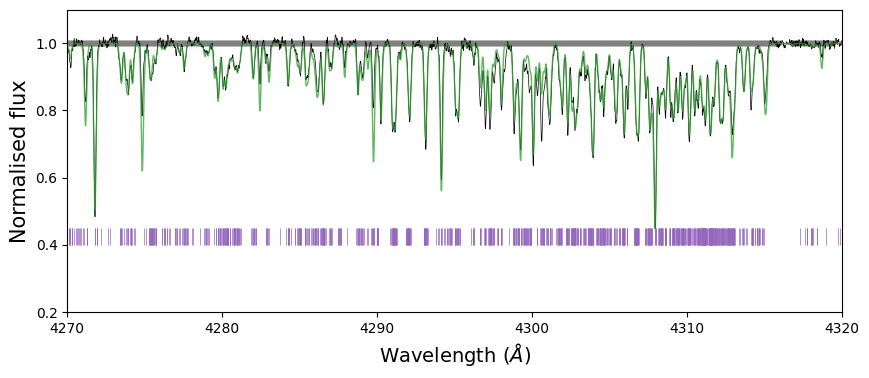

In [19]:
plt.figure(figsize=(10,4), dpi=100)

plt.plot(sme.wave.data, sme.spec.data, color='k', lw=0.5)
# plt.errorbar(sme.wave.data, sme.spec.data, fmt='k.', yerr=0.1*sme.uncs.data, lw=1, ms=1)
plt.plot(sme.wave.data, sme.synth.data, color='C2', lw=1.0, alpha=0.75)

plt.scatter(sme.wave.data, sme.mask.data, s=10, color='grey', alpha=0.2)

elems_to_include = ['CH 1']
for wline, species, ref in pd.DataFrame(ValdFile('linelist/CH_VALD_all.lin'))[['wlcent', 'species', 'reference']].values:
    if (wline < np.min(sme.wave.data)) or (wline > np.max(sme.wave.data)):
        continue
    if (species == 'Fe 1') | (species == 'Fe 2'):
        plt.vlines(wline, 0.2, 0.25, color='r')
    if species not in elems_to_include:
        continue
        
    plt.vlines(wline, 0.40, 0.45, color='C4', lw=0.5)
    # if '(12)CH' in ref: plt.annotate(text=r'$^{12}$%s' %species.split(' ')[0], xy=(wline-0.04, 0.3), rotation=90, fontsize=8)
    # if '(13)CH' in ref: plt.annotate(text=r'$^{13}$%s' %species.split(' ')[0], xy=(wline-0.04, 0.3), rotation=90, fontsize=8)
    
# plt.xlim(4229.6, 4233.4) #12C/13C
plt.xlim(4270, 4320) #CH
# plt.xlim(4315, 4330) #CH

plt.ylim(0.2, 1.1)

plt.xlabel(r'Wavelength ($\AA$)', size=14)
plt.ylabel('Normalised flux', size=15)
plt.show()

In [20]:
sme.fitresults.uncertainties

array([0.11060525])

In [29]:
#Merging files after SME

In [21]:
os.system('cat tmp_cayrel/cayrel_elem_c_*.csv > tmp_cayrel/cayrel_c.csv');
# os.system('cat tmp_cayrel/cayrel_elem_c12_*.csv > tmp_cayrel/cayrel_c12.csv');
# os.system('cat tmp_cayrel/cayrel_elem_c13_*.csv > tmp_cayrel/cayrel_c13.csv');

In [22]:
!head -n 2 tmp_cayrel/cayrel_c.csv

01_HD2796,7.712457073748045,0.18319713320933617,0.005101199776976825,11
02_HD122563,7.88703394453527,0.10874541476625145,0.002729569590077908,14


In [23]:
os.system("sed '1i spec_id,c,ec_sme,ec_fit,niter_c' tmp_cayrel/cayrel_c.csv -i");
# os.system("sed '1i spec_id,c12,ec12_sme,ec12_fit' tmp_cayrel/cayrel_c12.csv -i");
# os.system("sed '1i spec_id,c13,ec13_sme,ec13_fit' tmp_cayrel/cayrel_c13.csv -i");

In [47]:
#Merge carbon files with atm and Fe for Cayrel sample

In [67]:
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe.csv')
cayrel_c = pd.read_csv('tmp_cayrel/cayrel_c.csv')

cayrel_lelements = pd.read_csv('cayrel/Cayrel_light_elements.csv').query('species == "C"')
cayrel_lelements.drop(columns=['feh_c04', 'species', 'eafe', 'nlines_c04'], inplace=True)
cayrel_lelements.rename(columns={'loge':'logeC_c04', 'is_limit_am':'is_limit_c_c04', 'is_limit_afe':'is_limit_cfe_c04', 'afe':'cfe_c04', 'am':'cm_c04',}, inplace=True)
cayrel_lelements = cayrel_lelements[['spec_id', 'logeC_c04', 'is_limit_c_c04', 'cm_c04', 'cfe_c04', 'is_limit_cfe_c04']]

In [69]:
cayrel = cayrel.merge(right=cayrel_c, on='spec_id').merge(right=cayrel_lelements, on='spec_id')

In [71]:
cayrel.head(2)

,spec_id,teff,eteff_sme,eteff_fit,logg,elogg_sme,elogg_fit,monh,emonh_sme,emonh_fit,...,is_limit_fe2,c,ec_sme,ec_fit,niter_c,logeC_c04,is_limit_c_c04,cm_c04,cfe_c04,is_limit_cfe_c04
0,01_HD2796,4939.899305,204.934803,11.533078,1.851909,0.047986,0.047986,-2.349789,0.215940,0.013301,...,False,7.712457,0.183197,0.005101,11,5.55,False,-2.97,-0.51,False
1,02_HD122563,4581.238720,163.183116,8.732404,1.328129,0.060962,0.060962,-2.679967,0.186471,0.010661,...,False,7.887034,0.108745,0.002730,14,5.30,False,-3.22,-0.41,False


In [72]:
cayrel.to_csv('tmp_merged/cayrel_atm_fe_c.csv', header=True, index=False)

In [15]:
#Apply Placco corrections to the Cayrel sample

In [16]:
from selenium.webdriver.firefox.options import Options
from seleniumrequests import Firefox
import time

In [17]:
firefox_options = Options()
firefox_options.add_argument("--headless")
firefox_options.add_argument("--no-sandbox")
firefox_options.add_argument("--disable-dev-shm-usage")
firefox_options.set_preference("dom.forms.number", False)

In [21]:
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_cn.csv')
cayrel.columns

Index(['spec_id', 'teff', 'eteff_sme', 'eteff_fit', 'logg', 'elogg_sme',
       'elogg_fit', 'monh', 'emonh_sme', 'emonh_fit', 'vmic', 'evmic_sme',
       'evmic_fit', 'teff_cayrel', 'logg_cayrel', 'monh_cayrel', 'vmic_cayrel',
       'fe', 'efe_sme', 'efe_fit', 'vmac', 'evmac_sme', 'evmac_fit',
       'sme_vrad1', 'logeFe2', 'fe2', 'efe2_rms', 'efe2_sme', 'nlines_fe2',
       'is_limit_fe2', 'c', 'ec_sme', 'ec_fit', 'niter_c', 'logeC_c04',
       'is_limit_c_c04', 'cm_c04', 'cfe_c04', 'is_limit_cfe_c04', 'n',
       'en_sme', 'en_fit', 'niter_n', 'ch_s05', 'ech_s05', 'is_limit_ch_s05',
       'n_cn_s05', 'is_limit_n_cn_s05', 'n_nh_s05', 'en_nh_s05',
       'is_limit_n_nh_s05', 'nh_adopted_s05', 'is_limit_nh_adopted_s05',
       'oh_s05', 'cnfe_s05', 'is_limit_cnfe_s05', 'mixed_s05'],
      dtype='object')

In [22]:
def Placco_parallel(i, input_row):
    feh = np.round(input_row.fe + input_row.monh - solar.abund.get_element('Fe'), 2)
    cfe = np.round(input_row.c - solar.abund.get_element('C'), 2)
    lgg = input_row.logg - 0.3
    ff = Firefox(options=firefox_options)
    response = ff.request('POST', 'https://vplacco.pythonanywhere.com/', data={'lgg':lgg, 'feh':feh, 'cfe':cfe})
    carbon_correction = float(response.text.split('The [C/Fe] correction is: ')[1].split(' ([N/Fe]=0.0 case)')[0])
    ff.quit()

    data_to_write = np.vstack((input_row.spec_id, carbon_correction)).T
    pd.DataFrame(data=data_to_write, columns=['spec_id', 'carbon_correction']).to_csv('tmp_cayrel/cayrel_carbon_corrections_logg_03.csv', index=False, header=False, mode='a')
    time.sleep(np.random.randint(low=10, high=20))

    return

In [23]:
Parallel(n_jobs=3, verbose=5)(delayed(Placco_parallel)(i, input_row) for i, input_row in cayrel.iterrows());

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done  35 out of  35 | elapsed:  5.4min finished


In [24]:
!sed -i '1i \spec_id,carbon_correction_03' tmp_cayrel/cayrel_carbon_corrections_logg_03.csv

In [25]:
carbon_correction = pd.read_csv('tmp_cayrel/cayrel_carbon_corrections_logg_03.csv')

In [27]:
cayrel = cayrel.merge(right=carbon_correction, on='spec_id')

In [28]:
cayrel.head(2)

,spec_id,teff,eteff_sme,eteff_fit,logg,elogg_sme,elogg_fit,monh,emonh_sme,emonh_fit,...,n_nh_s05,en_nh_s05,is_limit_n_nh_s05,nh_adopted_s05,is_limit_nh_adopted_s05,oh_s05,cnfe_s05,is_limit_cnfe_s05,mixed_s05,carbon_correction_03
0,01_HD2796,4939.899305,204.934803,11.533078,1.851909,0.047986,0.047986,-2.349789,0.215940,0.013301,...,-1.22,0.08,False,-1.62,False,-1.97,0.14,False,m,0.40
1,02_HD122563,4581.238720,163.183116,8.732404,1.328129,0.060962,0.060962,-2.679967,0.186471,0.010661,...,-1.72,0.15,False,-2.12,False,-2.20,0.04,False,m,0.74


In [29]:
cayrel.to_csv('tmp_merged/cayrel_atm_fe_cn_corr.csv', index=False, header=True)

In [24]:
#Read and compare [C/H]

In [25]:
solar = SME_Structure()
solar.abund = Abund(0.0, 'asplund2009')

In [73]:
cayrel = pd.read_csv('tmp_merged/cayrel_atm_fe_c.csv')

In [74]:
cayrel.head(2)

,spec_id,teff,eteff_sme,eteff_fit,logg,elogg_sme,elogg_fit,monh,emonh_sme,emonh_fit,...,is_limit_fe2,c,ec_sme,ec_fit,niter_c,logeC_c04,is_limit_c_c04,cm_c04,cfe_c04,is_limit_cfe_c04
0,01_HD2796,4939.899305,204.934803,11.533078,1.851909,0.047986,0.047986,-2.349789,0.215940,0.013301,...,False,7.712457,0.183197,0.005101,11,5.55,False,-2.97,-0.51,False
1,02_HD122563,4581.238720,163.183116,8.732404,1.328129,0.060962,0.060962,-2.679967,0.186471,0.010661,...,False,7.887034,0.108745,0.002730,14,5.30,False,-3.22,-0.41,False


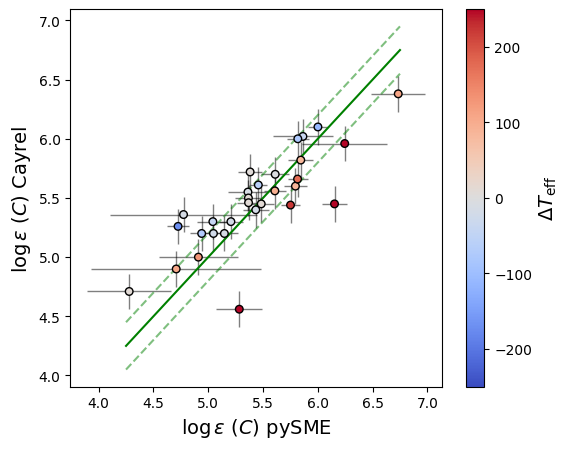

In [77]:
plt.figure(figsize=(6,5), dpi=100)

f_ec = (cayrel.ec_sme < 1.0)
plt.errorbar(cayrel.c.values[f_ec] + cayrel.monh.values[f_ec], cayrel.logeC_c04.values[f_ec], fmt='k.', 
             xerr=cayrel.ec_sme.values[f_ec], yerr=0.15*np.ones(np.sum(f_ec)), lw=1.0, zorder=0, alpha=0.5)
plt.scatter(cayrel.c.values[f_ec] + cayrel.monh.values[f_ec], cayrel.logeC_c04.values[f_ec], 
            c=(cayrel.teff.values[f_ec] - cayrel.teff_cayrel.values[f_ec]), s=30, ec='k', cmap=plt.cm.coolwarm, vmin=-250, vmax=250)
cb = plt.colorbar()
cb.set_label(label=r'$\Delta T_{\rm eff}$', size=14)
x = np.linspace(4.25, 6.75)
plt.plot(x,x,color='g', zorder=0)
plt.plot(x,x+0.2,color='g', ls='--', alpha=0.5, zorder=0)
plt.plot(x,x-0.2,color='g', ls='--', alpha=0.5, zorder=0)
plt.xlabel(r'$\log\epsilon\ (C)$ pySME', size=14)
plt.ylabel(r'$\log\epsilon\ (C)$ Cayrel', size=14)

# plt.xlim(3.5, 7)
# plt.ylim(4.0, 7)
plt.savefig('plots/UVES_carbon_comparison.pdf', dpi=300)
plt.show()

In [1]:
    # # For marcs2012 atmosphere
    # _default_grids = {
    #     "Al": "nlte_Al_ama51_pysme.grd",
    #     "Fe": "marcs2012_Fe2016.grd",
    #     "Li": "nlte_Li_ama51_pysme.grd",
    #     "Mg": "nlte_Mg_ama51_pysme.grd",
    #     "Na": "nlte_Na_ama51_pysme.grd",
    #     "O": "nlte_O_ama51_pysme.grd",
    #     "Ba": "nlte_Ba_ama51_pysme.grd",
    #     "Ca": "nlte_Ca_ama51_pysme.grd",
    #     "Si": "nlte_Si_ama51_pysme.grd",
    #     "Ti": "marcs2012s_t2.0_Ti.grd",
    #     "C": "nlte_C_ama51_pysme.grd",
    #     "H": "nlte_H_ama51_pysme.grd",
    #     "K": "nlte_K_ama51_pysme.grd",
    #     "Mn": "nlte_Mn_ama51_pysme.grd",
    #     "N": "nlte_N_ama51_pysme.grd",
    # }